In [10]:
!pip3 install -U sagemaker

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 685.8/685.8 kB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached importlib_metadata-4.13.0-py3-none-any.whl (23 kB)
  Created wheel for sagemaker: filename=sagemaker-2.142.0-py2.py3-none-any.whl size=927411 sha256=bd6cf5f239b8cb1b0d49968e3f4c27f671682fd48c19be727b8f745ffec6ce14
  Stored in directory: /home/ec2-user/.cache/pip/wheels/49/04/aa/652b947134316038c711253351915c31d532e59c06591da5ef
Successfully built sagemaker
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 6.1.0
    Uninstalling importlib-metadata-6.1.0:
      Successfully uninstalled importlib-metadata-6.1.0
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.132.0
    Uninstalling sagemaker-2.132.0:
      Successfully uninstalled sagemaker-2.132.0


In [1]:
import sagemaker
sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "SageMaker-output-2"

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role
role = get_execution_role()

In [3]:
conda install -c conda-forge pyarrow

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::bleach==5.0.1=pyhd8ed1ab_0
  - conda-forge/noarch::pytest==7.2.0=pyhd8ed1ab_2
  - conda-forge/noarch::python-lsp-jsonrpc==1.0.0=pyhd8ed1ab_0
  - conda-forge/noarch::qtpy==2.3.0=pyhd8ed1ab_0
  - conda-forge/linux-64::sip==6.7.5=py310hd8f1fbe_0
  - conda-forge/noarch::tqdm==4.64.1=pyhd8ed1ab_0
  - conda-forge/linux-64::watchdog==2.2.1=py310hff52083_0
  - conda-forge/noarch::dask-core==2022.11.0=pyhd8ed1ab_0
  - conda-forge/noarch::flask==2.2.2=pyhd8ed1ab_0
  - conda-forge/noarch::importlib_metadata==6.0.0=hd8ed1ab_0
  - conda-forge/noarch::nltk==3.8.1=pyhd8ed1ab_0
  - conda-forge/linux-64::pyqt5-sip==12.11.0=py310hd8f1fbe_2
  - conda-forge/noarch::python-lsp-server-base==1.7.0=pyhd8ed1ab_0
  - conda-forge/noarch::pytoolconfig==1.2.4=pyhd8ed1ab_1
  - conda-forge/noarch::qdarkstyle==3.0.3=pyhd8ed1ab_0
  - conda-forge

! aws s3 cp s3://imba-glue-output/sprint3-final-features/part-00000-d5ec00e2-c09f-4454-b38f-2cb5bf05918b-c000.snappy.parquet /home/ec2-user/SageMaker/

## IMBA Data Loading
1. final features stored as parquet in s3://imba-glue-output/sprint3-final-features/part-00000-d5ec00e2-c09f-4454-b38f-2cb5bf05918b-c000.snappy.parquet
2. final features stored as csv in s3://imba-glue-output/sprint2-2023-03-20-15:38:24/part-00000-137dfc27-7075-4bfc-8e89-f6ebcf31f795-c000.csv

In [14]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import seaborn as sns

s3 = boto3.client("s3")
s3_filepath = "s3://imba-glue-output/sprint3-final-features/part-00000-d5ec00e2-c09f-4454-b38f-2cb5bf05918b-c000.snappy.parquet"

In [15]:
feature_names = [
    "product_id",
    "user_id",
    "user_reorder_ratio",
    "avg_days_since_prior_order",
    "avg_addtocart_byuserprod"
]
data = pd.read_parquet(s3_filepath,columns=feature_names)
data[:5]

,product_id,user_id,user_reorder_ratio,avg_days_since_prior_order,avg_addtocart_byuserprod
0,28,15466,0.759191,11.312500,3.428571
1,28,22204,0.352941,18.500000,2.428571
2,28,22267,0.329670,12.263158,6.000000
3,28,26815,0.000000,30.000000,1.000000
4,28,32900,0.366337,24.142857,6.000000


<AxesSubplot: xlabel='avg_days_since_prior_order', ylabel='Density'>

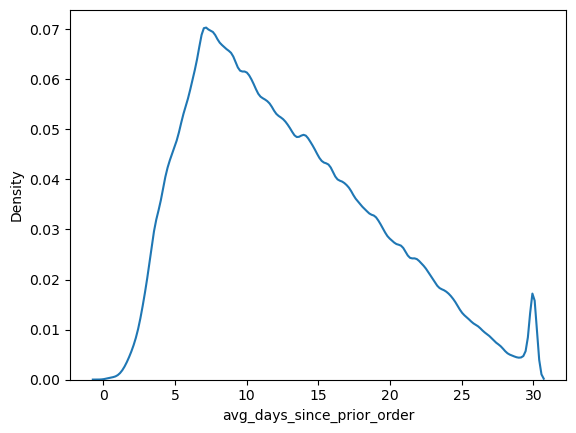

In [9]:
sns.kdeplot(data=data["avg_days_since_prior_order"])

<AxesSubplot: xlabel='avg_addtocart_byuserprod', ylabel='Density'>

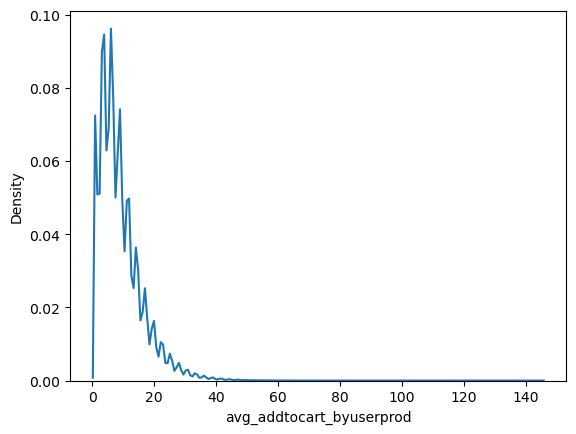

In [4]:
sns.kdeplot(data=data["avg_addtocart_byuserprod"])

In [16]:
# SageMaker XGBoost has the convention of label in the first column
# data = data[feature_names[-1:] + feature_names[:-1]]
data["product_id"] = data["product_id"].astype("category").cat.codes
data["user_id"] = data["user_id"].astype("category").cat.codes
data["avg_days_since_prior_order"] = pd.cut(data["avg_days_since_prior_order"], bins=6,
                                            labels=False, include_lowest=True)
data["avg_addtocart_byuserprod"] = pd.cut(data["avg_addtocart_byuserprod"], bins=[0, 5, 10, 15, 20, 40])
data["avg_addtocart_byuserprod"] = data["avg_addtocart_byuserprod"].astype("category").cat.codes
data[:5]

,product_id,user_id,user_reorder_ratio,avg_days_since_prior_order,avg_addtocart_byuserprod
0,27,15465,0.759191,2,0
1,27,22203,0.352941,3,0
2,27,22266,0.329670,2,1
3,27,26814,0.000000,5,0
4,27,32899,0.366337,4,1


In [17]:
# Split the downloaded data into train/test dataframes
train, test = np.split(data.sample(frac=1), [int(0.8 * len(data))])

train.to_parquet("imba_train.parquet")
test.to_parquet("imba_test.parquet")

In [7]:
train['product_id'].dtype

dtype('int32')

In [8]:
%%time
sagemaker.Session().upload_data(
    "imba_train.parquet", bucket=bucket, key_prefix=prefix + "/" + "training"
)

sagemaker.Session().upload_data(
    "imba_test.parquet", bucket=bucket, key_prefix=prefix + "/" + "validation"
)

CPU times: user 1.52 s, sys: 838 ms, total: 2.36 s
Wall time: 2.13 s


's3://sagemaker-ap-southeast-2-778725022589/SageMaker-output-2/validation/imba_test.parquet'

In [9]:
region = "ap-southeast-2"
container = sagemaker.image_uris.retrieve("xgboost", region, "1.7-1")

In [20]:
print(bucket)

sagemaker-ap-southeast-2-778725022589


In [21]:
bucket_path = "s3://{}".format(bucket)

## Training
1. code [ref](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/xgboost_abalone/xgboost_parquet_input_training.html)
2. parquet feature engineering [ref](https://www.kaggle.com/code/illidan7/amex-basic-feature-engineering-1500-features)

In [14]:
%%time
import time
from time import gmtime, strftime

client = boto3.client("sagemaker", region_name=region)
use_amt = True

training_job_name = "imba-xgboost-parquet-training-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Training job", training_job_name)

# Ensure that the training and validation data folders generated above are reflected in the "InputDataConfig" parameter below.

create_training_params = {
    "AlgorithmSpecification": {"TrainingImage": container, "TrainingInputMode": "Pipe"},
    "RoleArn": role,
    "OutputDataConfig": {"S3OutputPath": f"{bucket_path}/{prefix}/single-xgboost"},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.m5.2xlarge", "VolumeSizeInGB": 20},
    "TrainingJobName": training_job_name,
    "HyperParameters": {
        "max_depth": "5",
        "eta": "0.2",
        "gamma": "4",
        "min_child_weight": "6",
        "subsample": "0.7",
        "objective": "reg:linear",
        "num_round": "10",
        "verbosity": "2",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 3600},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": f"{bucket_path}/{prefix}/training",
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "application/x-parquet",
            "CompressionType": "None",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": f"{bucket_path}/{prefix}/validation",
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "application/x-parquet",
            "CompressionType": "None",
        },
    ],
}

print(
    f"Creating a training job with name: {training_job_name}..."
)
client.create_training_job(**create_training_params)

status = client.describe_training_job(TrainingJobName=training_job_name)["TrainingJobStatus"]
print(status)
while status != "Completed" and status != "Failed":
    time.sleep(60)
    status = client.describe_training_job(TrainingJobName=training_job_name)["TrainingJobStatus"]
    print(status)

Training job imba-xgboost-parquet-training-2023-03-29-02-42-15
Creating a training job with name: imba-xgboost-parquet-training-2023-03-29-02-42-15...
InProgress
InProgress
InProgress
Completed
CPU times: user 115 ms, sys: 1.32 ms, total: 116 ms
Wall time: 3min


## Import Model into host
1. code [ref](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/xgboost_mnist/xgboost_mnist.html)
2. model location: s3://sagemaker-ap-southeast-2-778725022589/SageMaker-output/single-xgboost/imba-xgboost-parquet-training-2023-03-25-12-04-21/output/model.tar.gz

In [15]:
%%time
from time import gmtime, strftime

model_name = f"{training_job_name}"
print(model_name)

training_name_of_model = training_job_name

info = client.describe_training_job(TrainingJobName=training_name_of_model)

model_data = info["ModelArtifacts"]["S3ModelArtifacts"]
print(model_data)

primary_container = {"Image": container, "ModelDataUrl": model_data}

create_model_response = client.create_model(
    ModelName=model_name, ExecutionRoleArn=role, PrimaryContainer=primary_container
)

print(create_model_response["ModelArn"])

imba-xgboost-parquet-training-2023-03-29-02-42-15
s3://sagemaker-ap-southeast-2-778725022589/SageMaker-output-2/single-xgboost/imba-xgboost-parquet-training-2023-03-29-02-42-15/output/model.tar.gz
arn:aws:sagemaker:ap-southeast-2:778725022589:model/imba-xgboost-parquet-training-2023-03-29-02-42-15
CPU times: user 8.81 ms, sys: 0 ns, total: 8.81 ms
Wall time: 533 ms


## Endpoint
1. Create endpoint configuration
2. Create Endpoint

In [16]:
from time import gmtime, strftime

endpoint_config_name = f'imba-XGBoostEndpointConfig2-{strftime("%Y-%m-%d-%H-%M-%S", gmtime())}'
print(endpoint_config_name)
create_endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m4.xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print(f'Endpoint Config Arn: {create_endpoint_config_response["EndpointConfigArn"]}')

imba-XGBoostEndpointConfig2-2023-03-29-02-45-58
Endpoint Config Arn: arn:aws:sagemaker:ap-southeast-2:778725022589:endpoint-config/imba-xgboostendpointconfig2-2023-03-29-02-45-58


In [17]:
%%time
import time

endpoint_name = f'imba-XGBoostEndpoint2-{strftime("%Y-%m-%d-%H-%M-%S", gmtime())}'
print(endpoint_name)
create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)
print(create_endpoint_response["EndpointArn"])

resp = client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print(f"Status: {status}")

while status == "Creating":
    time.sleep(60)
    resp = client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print(f"Status: {status}")

print(f'Arn: {resp["EndpointArn"]}')
print(f"Status: {status}")

imba-XGBoostEndpoint2-2023-03-29-02-46-04
arn:aws:sagemaker:ap-southeast-2:778725022589:endpoint/imba-xgboostendpoint2-2023-03-29-02-46-04
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:ap-southeast-2:778725022589:endpoint/imba-xgboostendpoint2-2023-03-29-02-46-04
Status: InService
CPU times: user 103 ms, sys: 8.75 ms, total: 112 ms
Wall time: 4min 1s


## Validate the model

In [11]:
runtime_client = boto3.client("runtime.sagemaker", region_name=region)

In [4]:
import sys

def do_predict(data, endpoint_name, content_type):
    payload = "\n".join(data)
    response = runtime_client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=payload
    )
    result = response["Body"].read().decode("ascii")
    preds = [num for num in result.split("\n")[:-1]]
    return preds

def batch_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    arrs = []
    for offset in range(0, items, batch_size):
        arrs.extend(
            do_predict(data[offset : min(offset + batch_size, items)], endpoint_name, content_type)
        )
        sys.stdout.write(".")
    return arrs

In [20]:
from sklearn.datasets import dump_svmlight_file

test_label = test['product_id']
test_value = test[test.columns.difference(['product_id'])]
dump_svmlight_file(test_value,test_label,'./test_svm_file')

In [12]:
%%time
import json

endpoint_name = "imba-XGBoostEndpoint2-2023-03-29-02-46-04"

file_name = "test_svm_file"
with open(file_name, "r") as f:
    payload = f.read().strip()

labels = [float(line.split(" ")[0]) for line in payload.split("\n")]
print(labels[0:5])
test_data = payload.split("\n")
preds = batch_predict(test_data, 100, endpoint_name, "text/x-libsvm")

print(
    "\nerror rate=%f"
    % (sum(1 for i in range(len(preds)) if preds[i] != labels[i]) / float(len(preds)))
)

[5453.0, 31677.0, 28843.0, 22120.0, 43121.0]
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [18]:
users_list = list(test["user_id"])
print(len(users_list))

2661591


In [23]:
test_data[0:5]

['5453 0:1 1:2 2:114009 3:0.5131578947368421',
 '31677 2:22439 3:0.7979334098737084',
 '28843 1:2 2:10107 3:0.4449152542372881',
 '22120 1:2 2:191289 3:0.4325842696629214',
 '43121 0:1 1:1 2:33409 3:0.70995670995671']

In [24]:
# test dataset prduct_id
labels[0:5]

[5453.0, 31677.0, 28843.0, 22120.0, 43121.0]

In [40]:
[int(float(pred)) for pred in preds]

[22786,
 17262,
 17262,
 17262,
 22786,
 17262,
 22786,
 22786,
 22786,
 17262,
 22786,
 17262,
 22786,
 22786,
 17262,
 22786,
 22786,
 22786,
 22786,
 22786,
 17262,
 21513,
 22786,
 22786,
 22786,
 22786,
 22786,
 22786,
 22786,
 22786,
 22786,
 17262,
 17262,
 22786,
 22786,
 22786,
 22786,
 22786,
 17262,
 17262,
 22786,
 22786,
 22786,
 22786,
 22786,
 22786,
 17262,
 17262,
 17262,
 22786,
 22786,
 22786,
 17262,
 17262,
 22786,
 22786,
 22786,
 22786,
 17262,
 22786,
 22786,
 17262,
 22786,
 22786,
 17262,
 22786,
 22786,
 22786,
 22786,
 17262,
 22786,
 17262,
 22786,
 17262,
 17262,
 17262,
 22786,
 22786,
 22786,
 22786,
 22786,
 22786,
 22786,
 22786,
 22786,
 17262,
 22786,
 22786,
 17262,
 22786,
 22786,
 22786,
 22786,
 22786,
 17262,
 22786,
 22786,
 22786,
 17262,
 22786,
 17262,
 22786,
 22786,
 17262,
 22786,
 22786,
 22786,
 22786,
 17262,
 17262,
 17262,
 22786,
 22786,
 22786,
 22786,
 22786,
 17262,
 17262,
 22786,
 22786,
 17262,
 22786,
 22786,
 22786,
 22786,


In [50]:
# convert preds and users_list lists into json
users_list_5000 = users_list[:5000]
preds_5000 = preds[:5000]
print(type(preds_5000), type(users_list_5000))

#output_json_5000 = json.dumps([{'user_id': user, 'pred_product_id': pred} 
#                          for user, pred in zip(users_list_5000, preds_5000)])
output_json_5000 = []
for user, pred in zip(users_list_5000, preds_5000):
    output_json_5000.append({'user_id': user, 'pred_product_id':pred})
output_json_5000 = json.dumps(output_json_5000)

<class 'list'> <class 'list'>


In [51]:
s3.put_object(
     Body=output_json_5000,
     Bucket='imba-charlie-test-111',
     Key='sagemaker_predictions/user_pred_5000.json'
)

{'ResponseMetadata': {'RequestId': 'CKTEXKBPB36SXWX1',
  'HostId': 'wZZZNdQAUCxxOVY9t5IGaqwRy/XogjIS8OLGi5g9eF3+e7nAI9R508v8LZ/hUjbG2T34OrgRxL8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'wZZZNdQAUCxxOVY9t5IGaqwRy/XogjIS8OLGi5g9eF3+e7nAI9R508v8LZ/hUjbG2T34OrgRxL8=',
   'x-amz-request-id': 'CKTEXKBPB36SXWX1',
   'date': 'Wed, 29 Mar 2023 03:50:12 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"0f5108c4915d8a815da36c704afbfdd2"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"0f5108c4915d8a815da36c704afbfdd2"',
 'ServerSideEncryption': 'AES256'}

In [58]:
batch_size = 5000
for i in range(0, len(users_list), batch_size):
    batch_users = users_list[i:i+batch_size]
    batch_preds = preds[i:i+batch_size]
    output = []
    for user, pred in zip(batch_users, batch_preds):
        output.append({'user_id':user, 'pred_product_id':pred})
    output_json = json.dumps(output)
    
    batch_key = f"sagemaker_predictions/{len(output_json)}.json"
    
    #for key, data in zip(batch_key, output_json):
        #s3.put_object(Bucket="imba-charlie-test-111", Key=key, Body=data)
    s3.put_object(Bucket="imba-charlie-test-111", Key=batch_key, Body=output_json)

## Evaluate

In [32]:
def error_rate(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(predictions == labels)
    #total = predictions.shape[0]
    total = len(predictions)

    error = 100.0 - (100 * float(correct) / float(total))

    #confusions = np.zeros([10, 10], np.int32)
    #bundled = zip(predictions, labels)
    #for predicted, actual in bundled:
    #    confusions[int(float(predicted)), int(actual)] += 1

    return error

In [33]:
error_rate(preds, labels)

100.0

## Delete Endpoint

In [60]:
client = boto3.client("sagemaker", region_name=region)
client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '71e22f58-1b2f-40e1-b767-1b7b95ff15b7',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '71e22f58-1b2f-40e1-b767-1b7b95ff15b7',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 29 Mar 2023 04:17:00 GMT'},
  'RetryAttempts': 0}}